In [1]:
import os

import uuid

import pandas as pd
import numpy as np
from pandas.core.common import random_state

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score

import matplotlib.pyplot as plt

import mlflow
from mlflow import MlflowClient
from mlflow.exceptions import MlflowException

%matplotlib inline

In [156]:
client = MlflowClient()
experiment_name = "Creditcard_fraud_detection"
mlflow.autolog(disable=True)

In [157]:
# Handling experiment creation
try:
    experiment_id = client.create_experiment(experiment_name)
    print(f"Experiment created with ID: {experiment_id}")
except MlflowException as e:
    if 'already exists' in str(e):
        experiment_id = client.get_experiment_by_name(experiment_name).experiment_id
        print(f"Experiment already exists. Using existing experiment with ID: {experiment_id}")
    else:
        print(f"An error occurred: {e}")
        raise

Experiment already exists. Using existing experiment with ID: 693275486830425532


In [158]:
fraud_experiment = mlflow.set_experiment(experiment_name)

In [159]:
def generate_run_name(base_name):
    random_string = uuid.uuid4().hex[:8]
    return f"{base_name}_{random_string}"

In [160]:
def load_dataset(path='data/creditcard_2023.csv', n=1000):
    return pd.read_csv(path, index_col=0).sample(n)

In [161]:
df = load_dataset(n=50000)

# Classification target: 'Class'
y = df[['Class']]
X = df.drop(columns=['Class'], axis=1)

In [162]:
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [163]:
scaler = MinMaxScaler()
x_train[['Amount']] = scaler.fit_transform(x_train[['Amount']])
x_test[['Amount']] = scaler.fit_transform(x_test[['Amount']])

In [164]:
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

### Random forest algorithm



Accuracy score: 0.9978
Recall score: 0.9961816720257235
R2 score: 0.9911997972433285
Confusion matrix:
[[5021    3]
 [  19 4957]]


C:\Users\andre\PycharmProjects\mlflow\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


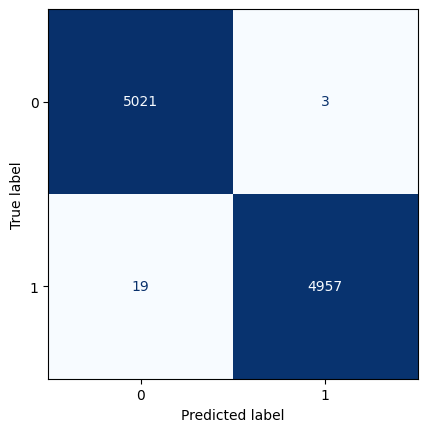

In [165]:
# Random forest
with mlflow.start_run(run_name=generate_run_name('random_forest')) as run:

    rf_params = {
        'random_state': 42
    }

    rf = RandomForestClassifier(**rf_params)
    rf.fit(x_train, y_train)

    # Predict
    y_pred_rf = rf.predict(x_test)

    rf_acc = accuracy_score(y_test, y_pred_rf)
    print(f'\n\nAccuracy score: {rf_acc}')

    recall_rf = recall_score(y_test, y_pred_rf)
    print(f'Recall score: {recall_rf}')

    rf_r2 = r2_score(y_test, y_pred_rf)
    print(f'R2 score: {rf_r2}')

    rf_cm = confusion_matrix(y_test, y_pred_rf)
    print(f'Confusion matrix:\n{rf_cm}')

    # Assemble the metrics we're going to write into a collection
    rf_metrics = {'accuracy': rf_acc, 'recall': recall_rf, 'r2': rf_r2}

    mlflow.log_params(rf_params)
    mlflow.log_metrics(rf_metrics)

    mlflow.sklearn.log_model(
        sk_model=rf, input_example=x_test.head(10), artifact_path='artifacts'
    )

    disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
    disp.plot(cmap="Blues", colorbar=False)

    # Save the plot as an image file
    cm_image_path = "rf_confusion_matrix.png"
    plt.savefig(cm_image_path)
    plt.show()

    # Log the image file to MLflow
    mlflow.log_artifact(cm_image_path)

    # Clean up local image file if needed
    os.remove(cm_image_path)


### Support Vectors algorithm



Accuracy score: 0.9888
Recall score: 0.9857315112540193
R2 score: 0.9551989677842178
Confusion matrix:
[[4983   41]
 [  71 4905]]


C:\Users\andre\PycharmProjects\mlflow\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


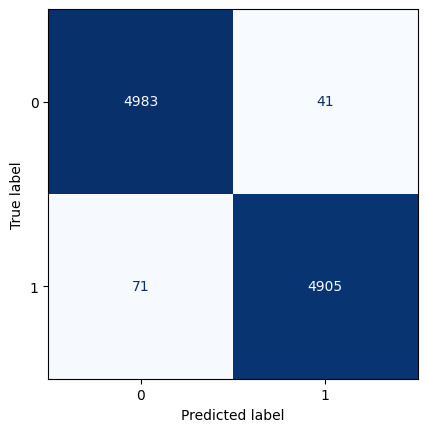

In [166]:
# Support Vectors
with mlflow.start_run(run_name=generate_run_name('support_vectors')) as run:
    sv_params = {
        'random_state': 42
    }

    svc = SVC(**sv_params)
    svc.fit(x_train, y_train)

    # Predict
    y_pred_svc = svc.predict(x_test)

    svc_acc = accuracy_score(y_test, y_pred_svc)
    print(f'\n\nAccuracy score: {svc_acc}')

    recall_svc = recall_score(y_test, y_pred_svc)
    print(f'Recall score: {recall_svc}')

    svc_r2 = r2_score(y_test, y_pred_svc)
    print(f'R2 score: {svc_r2}')

    mlflow.log_params(sv_params)

    sv_metrics = {'accuracy': svc_acc, 'recall': recall_svc, 'r2': svc_r2}
    mlflow.log_metrics(sv_metrics)

    svc_cm = confusion_matrix(y_test, y_pred_svc)
    print(f'Confusion matrix:\n{svc_cm}')

    mlflow.sklearn.log_model(
        sk_model=svc, input_example=x_test.head(10), artifact_path='artifacts'
    )


    disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm)
    disp.plot(cmap="Blues", colorbar=False)

    # Save the plot as an image file
    cm_image_path = "svc_confusion_matrix.png"
    plt.savefig(cm_image_path)
    plt.show()

    # Log the image file to MLflow
    mlflow.log_artifact(cm_image_path)

    # Clean up local image file if needed
    os.remove(cm_image_path)

### Logistic Regression



Accuracy score: 0.9674
Recall score: 0.9535771704180064
R2 score: 0.8695969955147766
Confusion matrix:
[[4929   95]
 [ 231 4745]]


C:\Users\andre\PycharmProjects\mlflow\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


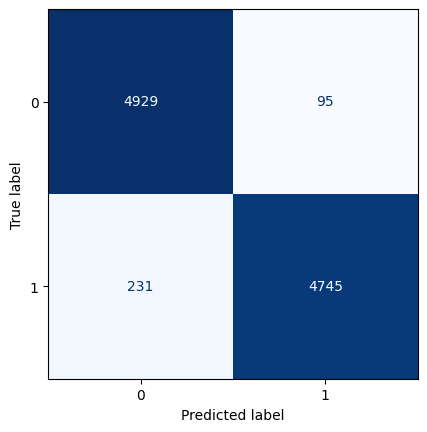

In [167]:
# Logistic Regression
with mlflow.start_run(run_name=generate_run_name('logistic_regression')) as run:
    lr_params = {
        'random_state': 42,
        'max_iter': 1000
    }

    logistic_reg = LogisticRegression(**lr_params)
    logistic_reg.fit(x_train, y_train)

    # Predict
    y_pred_lr = logistic_reg.predict(x_test)

    lr_acc = accuracy_score(y_test, y_pred_lr)
    print(f'\n\nAccuracy score: {lr_acc}')

    recall_lr = recall_score(y_test, y_pred_lr)
    print(f'Recall score: {recall_lr}')

    lr_r2 = r2_score(y_test, y_pred_lr)
    print(f'R2 score: {lr_r2}')

    mlflow.log_params(lr_params)

    lr_metrics = {'accuracy': lr_acc, 'recall': recall_lr, 'r2': lr_r2}
    mlflow.log_metrics(lr_metrics)

    lr_cm = confusion_matrix(y_test, y_pred_lr)
    print(f'Confusion matrix:\n{lr_cm}')

    mlflow.sklearn.log_model(
        sk_model=logistic_reg, input_example=x_test.head(10), artifact_path='artifacts'
    )

    disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm)
    disp.plot(cmap="Blues", colorbar=False)

    # Save the plot as an image file
    cm_image_path = "lr_confusion_matrix.png"
    plt.savefig(cm_image_path)
    plt.show()

    # Log the image file to MLflow
    mlflow.log_artifact(cm_image_path)

    # Clean up local image file if needed
    os.remove(cm_image_path)


## Grid Search (hyperparameters optimization)

### SVM Grid Search

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Accuracy score: 0.9965
Recall score: 0.997588424437299
R2 score: 0.985999677432568
Confusion matrix:
[[5001   23]
 [  12 4964]]


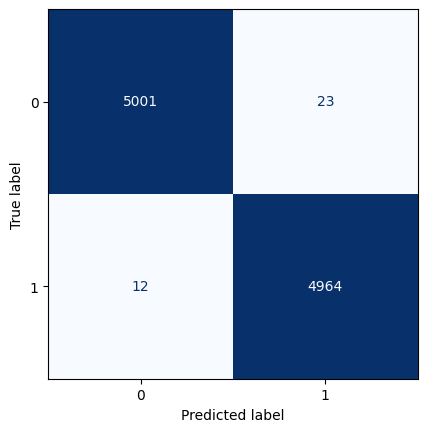

C:\Users\andre\PycharmProjects\mlflow\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [168]:
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}

with mlflow.start_run(run_name=generate_run_name("svc_grid_search")) as run:

    # Define the model
    svc = SVC(random_state=42)

    # GridSearchCV
    grid_search_svc = GridSearchCV(
        estimator=svc,
        param_grid=svc_param_grid,
        scoring='recall',  # maximize recall
        cv=3,
        n_jobs=-1,
        verbose=1,
        refit=True
    )

    # Fit the grid search
    grid_search_svc.fit(x_train, y_train)

    # Extract best estimator and params
    best_svc = grid_search_svc.best_estimator_
    best_params_svc = grid_search_svc.best_params_

    mlflow.log_params(best_params_svc)  # Log best hyperparams

    # Predict on test
    y_pred_svc = best_svc.predict(x_test)

    # -- Metrics (Logging style updated here) --
    svc_acc = accuracy_score(y_test, y_pred_svc)
    print(f"\n\nAccuracy score: {svc_acc}")

    recall_svc = recall_score(y_test, y_pred_svc)
    print(f"Recall score: {recall_svc}")

    svc_r2 = r2_score(y_test, y_pred_svc)
    print(f"R2 score: {svc_r2}")

    svc_metrics = {'accuracy': svc_acc, 'recall': recall_svc, 'r2': svc_r2}
    mlflow.log_metrics(svc_metrics)

    svc_cm = confusion_matrix(y_test, y_pred_svc)
    print(f"Confusion matrix:\n{svc_cm}")

    # Plot confusion matrix and log as artifact
    disp_svc = ConfusionMatrixDisplay(confusion_matrix=svc_cm)
    disp_svc.plot(cmap="Blues", colorbar=False)
    svc_cm_image_path = "svc_confusion_matrix.png"
    plt.savefig(svc_cm_image_path)
    plt.show()
    mlflow.log_artifact(svc_cm_image_path)
    os.remove(svc_cm_image_path)

    # Log the best model
    mlflow.sklearn.log_model(
        sk_model=best_svc,
        input_example=x_test.head(10),
        artifact_path="artifacts"
    )

### Logistic Regression Grid Search

Fitting 3 folds for each of 24 candidates, totalling 72 fits


Accuracy score: 0.9674
Recall score: 0.9539790996784566
R2 score: 0.8695969955147766
Confusion matrix:
[[4927   97]
 [ 229 4747]]


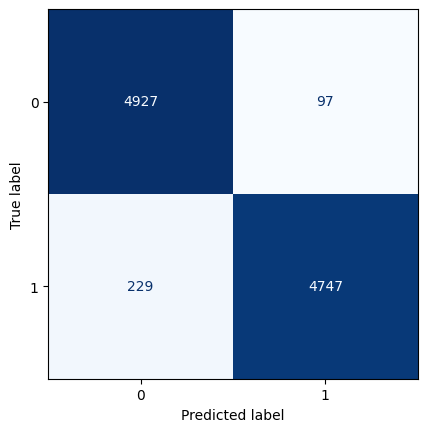

C:\Users\andre\PycharmProjects\mlflow\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [169]:
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10],
    'penalty': ['l2'],  # 'l1' requires solver='liblinear' or 'saga'
    'class_weight': [None, 'balanced'],
    'max_iter': [200, 500, 1000]
}

with mlflow.start_run(run_name=generate_run_name("lr_grid_search")) as run:

    logistic_reg = LogisticRegression(random_state=42)

    grid_search_lr = GridSearchCV(
        estimator=logistic_reg,
        param_grid=lr_param_grid,
        scoring='recall',
        cv=3,
        n_jobs=-1,
        verbose=1,
        refit=True
    )

    grid_search_lr.fit(x_train, y_train)

    best_lr = grid_search_lr.best_estimator_
    best_params_lr = grid_search_lr.best_params_

    mlflow.log_params(best_params_lr)  # Log best hyperparams

    # Predict on test
    y_pred_lr = best_lr.predict(x_test)

    # -- Metrics (Logging style updated here) --
    lr_acc = accuracy_score(y_test, y_pred_lr)
    print(f"\n\nAccuracy score: {lr_acc}")

    recall_lr = recall_score(y_test, y_pred_lr)
    print(f"Recall score: {recall_lr}")

    lr_r2 = r2_score(y_test, y_pred_lr)
    print(f"R2 score: {lr_r2}")

    # Log metrics in a dictionary
    lr_metrics = {'accuracy': lr_acc, 'recall': recall_lr, 'r2': lr_r2}
    mlflow.log_metrics(lr_metrics)

    lr_cm = confusion_matrix(y_test, y_pred_lr)
    print(f"Confusion matrix:\n{lr_cm}")

    # Confusion matrix artifact
    disp_lr = ConfusionMatrixDisplay(confusion_matrix=lr_cm)
    disp_lr.plot(cmap="Blues", colorbar=False)
    lr_cm_image_path = "lr_confusion_matrix.png"
    plt.savefig(lr_cm_image_path)
    plt.show()
    mlflow.log_artifact(lr_cm_image_path)
    os.remove(lr_cm_image_path)

    # Log the best model
    mlflow.sklearn.log_model(
        sk_model=best_lr,
        input_example=x_test.head(10),
        artifact_path="best_lr_model"
    )